## Implementation of domain adversarial networks

This is based on the following paper: <i>Domain-Adversarial Neural Networks</i>.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input,Dense,Dropout,Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,balanced_accuracy_score
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")

In [2]:
## feature extraction using pretrained feature extractor
universal_embed = hub.load("../other/universal-sentence-encoder_4")
nnlm_embed = hub.load("../other/nnlm-en-dim128_2")

In [3]:
## getting the data from the different distributions
def get_data(file_name,data_dir="../data/sentiment/"):
    """ returns the sentiment data for the given file
    """
    all_text = []
    all_labels = []
    with open(data_dir+file_name) as data_file:
        for line in data_file.readlines():
            text,label = line.split("\t")
            all_text.append(text.lower())
            all_labels.append(int(label))
    return np.asarray(all_text),np.asarray(all_labels)

amazon_x,amazon_y = get_data("amazon.txt")
imdb_x,imdb_y = get_data("imdb.txt")
print(amazon_x.shape,amazon_y.shape,imdb_x.shape,imdb_y.shape)
amazon_x = np.hstack([universal_embed(amazon_x),nnlm_embed(amazon_x)])
imdb_x = np.hstack([universal_embed(imdb_x),nnlm_embed(imdb_x)])
print(amazon_x.shape,imdb_x.shape)

(1000,) (1000,) (1000,) (1000,)
(1000, 640) (1000, 640)


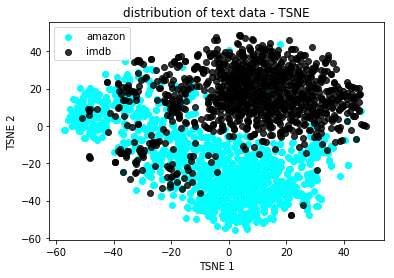

In [4]:
## initial distribution of the data
pca = PCA(n_components=200)
both_features = np.vstack([amazon_x,imdb_x])
combined_pca = pca.fit_transform(both_features)
#print(sum(pca.explained_variance_ratio_))

tsne_embed = TSNE(n_components=2).fit_transform(combined_pca)
tsne_amazon = tsne_embed[:1000,:]
tsne_imdb = tsne_embed[1000:,:]
plt.scatter(tsne_amazon[:,0],tsne_amazon[:,1],color="cyan",label="amazon",)
plt.scatter(tsne_imdb[:,0],tsne_imdb[:,1],color="black",label="imdb",alpha=0.8)
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("distribution of text data - TSNE")
plt.legend()
plt.show()

In [4]:
# Amazon data is the source, IMDB is the target
x_train,x_test,y_train,y_test = train_test_split(amazon_x,amazon_y,test_size=0.1,random_state=2)
y_test = np.expand_dims(y_test,axis=-1)
x_test,y_test = x_test.astype("float32"),y_test.astype("float32")
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(900, 640) (100, 640) (900,) (100, 1)


In [5]:
# Combining the IMDB data with the Amazon data in unsupervised fashion
task_loss_mask = np.concatenate([np.ones((len(x_train))),np.zeros((len(imdb_x)))]) # Amazon:1.0, IMDB:0.0
class_labels = np.concatenate([np.ones((len(x_train))),np.zeros((len(imdb_x)))]) # Amazon:1, IMDB:0
x_train = np.vstack([x_train,imdb_x])
y_train = np.concatenate([y_train,imdb_y]) # the imdb labels will be canceled out by task_loss_mask
y_train = np.expand_dims(y_train,axis=-1)

task_loss_mask,class_labels,x_train,y_train = task_loss_mask.astype("float32"),class_labels.astype("float32"),x_train.astype("float32"),y_train.astype("float32")
task_loss_mask,class_labels,x_train,y_train = shuffle(task_loss_mask,class_labels,x_train,y_train)
print(task_loss_mask.shape,class_labels.shape,x_train.shape,y_train.shape)

(1900,) (1900,) (1900, 640) (1900, 1)


### DANN Modeling

In this setting, it is assumed there are no labels for the IMDB data; it is simply fed to the model in an unsupervised fashion to push the DANN to have domain-invariant qualities (with respect to Amazon <-> IMDB). This means there is a loss_mask associated with the IMDB data with respect to the task_loss. Note: this could easily be updated to work in a semi-supervised setting, by not having the loss_mask cancel out the task_loss contributions for all the IMDB data points.

In [6]:
# defining the gradient-reversal layer
@tf.custom_gradient
def reverse_grad(x):
    """ identity function during forward_pass: f(x)=x; -1 gradient: f'(x)=-1
    """
    y = tf.identity(x)
    def custom_grad(dy):
        return -dy
    return y,custom_grad

## grad_reverse only seems to work in Model as part of keras layer
class ReverseGrad(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
    def call(self,x):
        return reverse_grad(x)

In [7]:
def dann_network(input_dim=640):
    """ Defines forward pass of DANN network; includes both a class prediction(minimize acc.) and task prediction(maximize acc.)
        -the idea is to also update the parameters of the model to maximize class confusion (minimize class prediction performance)
    """
    x = Input(shape=(input_dim))
    h1 = Dense(256,activation="relu")(x)
    h1_inner = ReverseGrad()(h1) # reverses the gradient going to the class prediction
    class_pred = Dense(1,activation="sigmoid")(h1_inner) # predicting the class of the input (Amazon vs IMDB)
    task_pred = Dense(1,activation="sigmoid")(h1) # predicting sentiment label
    
    model = Model(inputs=[x],outputs=[task_pred,class_pred,h1])
    return model

In [8]:
model = dann_network()

In [9]:
def dann_loss(task_y,task_pred,task_loss_mask,class_y,class_pred,task_lam):
    """ DANN loss function - includes cross-entropy losses for task,class predictions
    args:
        task_loss_mask: mask to cancel out class predictions for IMDB data points
        task_lam: loss contribution for the task classification loss [0-1]
    """
    task_loss = K.binary_crossentropy(task_y,task_pred)
    task_loss *= task_loss_mask
    task_loss = tf.reduce_mean(task_loss)
    
    class_loss = BinaryCrossentropy()(class_y,class_pred) # automatic avg over batch
    total_loss = (task_lam*task_loss)+((1-task_lam)*class_loss)
    return total_loss

In [10]:
@tf.function
def train(model,optimizer,x_train_subset,y_train_subset,loss_mask_subset,class_subset,task_lam=0.75):
    with tf.GradientTape() as tape:
        task_pred,class_pred,_ = model(x_train_subset)
        loss = dann_loss(y_train_subset,task_pred,loss_mask_subset,class_subset,class_pred,task_lam)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [11]:
# for comparison, the standard model trained only on Amazon data (task_lam=1) results in IMDB acc and bal_acc of 86%
batch_size=25
optimizer=Adam(lr=0.001)
epochs=5

for epoch_i in range(epochs):
    losses = []
    for i in range(0,len(x_train),batch_size):
        x_train_subset = x_train[i:i+batch_size]
        y_train_subset = y_train[i:i+batch_size]
        loss_mask_subset = task_loss_mask[i:i+batch_size]
        class_subset = class_labels[i:i+batch_size]
        batch_loss = train(model,optimizer,x_train_subset,y_train_subset,loss_mask_subset,class_subset)
        losses.append(float(batch_loss))
    
    print("epoch {}; loss:{}".format(epoch_i,round(sum(losses)/len(losses),4)))
    y_train_pred,train_class_pred,_ = model(x_train)
    y_train_pred = y_train_pred.numpy()
    y_train_pred[y_train_pred >= 0.5]=1 ; y_train_pred[y_train_pred < 0.5]=0
    train_class_pred = train_class_pred.numpy()
    train_class_pred[train_class_pred >= 0.5]=1 ; train_class_pred[train_class_pred < 0.5]=0
    
    y_test_pred,_,_ = model(x_test)
    y_test_pred = y_test_pred.numpy()
    y_test_pred[y_test_pred >= 0.5]=1 ; y_test_pred[y_test_pred < 0.5]=0
    
    imdb_pred,_,_ = model(imdb_x)
    imdb_pred = imdb_pred.numpy()
    imdb_pred[imdb_pred >= 0.5]=1 ; imdb_pred[imdb_pred < 0.5]=0
    
    train_acc,train_bal_acc = round(accuracy_score(y_train,y_train_pred),4),round(balanced_accuracy_score(y_train,y_train_pred),4)
    test_acc,test_bal_acc = round(accuracy_score(y_test,y_test_pred),4),round(balanced_accuracy_score(y_test,y_test_pred),4)
    imdb_acc,imdb_bal_acc = round(accuracy_score(imdb_y,imdb_pred),4),round(balanced_accuracy_score(imdb_y,imdb_pred),4)
    train_class_acc = round(accuracy_score(class_labels,train_class_pred),4)
    
    print("-Train; accuracy:{}; bal_accuracy:{}".format(train_acc,train_bal_acc))
    print("-Test; accuracy:{}; bal_accuracy:{}".format(test_acc,test_bal_acc))
    print("-IMDB; accuracy:{}; bal_accuracy:{}".format(imdb_acc,imdb_bal_acc))
    print("-Class confusion accuracy(train):{}".format(train_class_acc))

epoch 0; loss:0.4443
-Train; accuracy:0.8832; bal_accuracy:0.8837
-Test; accuracy:0.93; bal_accuracy:0.9215
-IMDB; accuracy:0.873; bal_accuracy:0.873
-Class confusion accuracy(train):0.07
epoch 1; loss:0.2725
-Train; accuracy:0.8989; bal_accuracy:0.8995
-Test; accuracy:0.93; bal_accuracy:0.9215
-IMDB; accuracy:0.886; bal_accuracy:0.886
-Class confusion accuracy(train):0.9258
epoch 2; loss:0.1996
-Train; accuracy:0.9105; bal_accuracy:0.911
-Test; accuracy:0.95; bal_accuracy:0.9419
-IMDB; accuracy:0.898; bal_accuracy:0.898
-Class confusion accuracy(train):0.7111
epoch 3; loss:0.2336
-Train; accuracy:0.9174; bal_accuracy:0.9178
-Test; accuracy:0.95; bal_accuracy:0.9419
-IMDB; accuracy:0.906; bal_accuracy:0.906
-Class confusion accuracy(train):0.5779
epoch 4; loss:0.2683
-Train; accuracy:0.9226; bal_accuracy:0.923
-Test; accuracy:0.95; bal_accuracy:0.9419
-IMDB; accuracy:0.911; bal_accuracy:0.911
-Class confusion accuracy(train):0.4216
